In [61]:
import pandas as pd
import numpy as np
import matplotlib.pyplot  as plt
import matplotlib.image as mpimg
from scipy import stats
import ast
import re

import spacy
from spacy import displacy
from spacy.tokens import DocBin
from tqdm import tqdm
from spacy.util import filter_spans

# Dataset overview

To start, it is necessary to make or select a dataset with names of mountains for further work with it. After a small search in the Internet was found a dataset on [Kaggle](https://www.kaggle.com/datasets/geraygench/mountain-ner-dataset/data), which contains sentences with labeled names of mountains. Therefore, we will take it as a basis.
Let's take a look at it

In [28]:
df_m = pd.read_csv('mountain_dataset_with_markup.csv')

In [29]:
df_m.head(15)

,text,marker
0,A visit to a science museum for hands-on learn...,[]
1,Voice surface coach set democratic time year. ...,[]
2,Parent according maybe activity activity finis...,[]
3,A visit to a sculpture garden with intriguing ...,[]
4,The Julian Alps in Slovenia offer pristine lak...,"[(11, 15)]"
5,"The referee blows the whistle, signaling the e...",[]
6,Again eat owner drop. Stay recognize none size...,[]
7,Important nearly themselves particular sort cl...,[]
8,Wonder behind everybody dream. Owner much anal...,[]
9,Phone station white leave image.\nSeem Mrs bed...,[]


In [30]:
df_m.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1584 entries, 0 to 1583
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    1584 non-null   object
 1   marker  1584 non-null   object
dtypes: object(2)
memory usage: 24.9+ KB


It is notable that not all sentences among 1584 have a marker for the name of mountains. In the future we will select only the necessary sentences, since the model does not need empty ones for training.

Let's start cleaning the dataset from unnecessary rows (with empty marker) and checking for problematic characters/values

In [31]:
# Check the lines for NaN values
df_m.isna().sum()

text      0
marker    0
dtype: int64

In [32]:
# Convert the string representation of lists into real lists
df_m['marker'] = df_m['marker'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)

# Filter rows where 'marker' is not empty (the list contains items)
filtered_df = df_m[df_m['marker'].apply(lambda x: len(x) > 0)]
filtered_df.loc[:, 'marker'] = filtered_df['marker'].apply(lambda x: x[0] if isinstance(x, list) and len(x) > 0 else x)

In [33]:
filtered_df

,text,marker
4,The Julian Alps in Slovenia offer pristine lak...,"(11, 15)"
13,The Dolomites in Italy are famous for their un...,"(4, 13)"
21,Feeling the tranquility and serenity of the An...,"(44, 49)"
22,The Carpathian Mountains are a vital part of E...,"(4, 24)"
28,"I explored the Tatra Mountains, a beautiful ra...","(15, 30)"
...,...,...
1547,Discover hidden waterfalls and serene lakes ne...,"(63, 80)"
1555,I trekked through the Tien Shan mountains in C...,"(22, 31)"
1565,I marveled at the beauty of the Blue Ridge Mou...,"(32, 52)"
1577,The Kunlun Mountains stretch across western Ch...,"(4, 20)"


After cleaning up the dataset, 226 rows remained

To give an example, let's try to get the name of the mountains from the first sentence based on the marker

In [34]:
filtered_df['text'].iloc[0][filtered_df['marker'].iloc[0][0]:filtered_df['marker'].iloc[0][1]]

'Alps'

Let's do a little checking for problematic characters, links, tags and the like.

In [36]:
def preprocess_and_find_problems(text_column):
    # Dictionary to store results
    results = {
        'index': [],
        'original_text': [],
        'cleaned_text': [],
        'removed_links': [],
        'removed_telegram_links': [],
        'removed_phone_numbers': [],
        'removed_tags': [],
        'removed_hashtags': [],
        'removed_special_chars': [],
        'removed_extra_spaces': []
    }

    # Regular expressions
    link_pattern = r'http\S+|www.\S+'  # Pattern for detecting regular links
    telegram_pattern = r"(?:https?:\/\/)?(?:www\.)?(?:t\.me\/\S+|telegram\.me\/\S+|telegram\.dog\/\S+)"  # Telegram links
    phone_pattern = r'\(?\+?\d{0,3}\)?[-.\s]?\(?\d{3}\)?[-.\s]?\d{3}[-.\s]?\d{2}[-.\s]?\d{2}'  # Phone numbers
    tag_pattern = r'@\w+'  # Tags (e.g., @username)
    hashtag_pattern = r'#\w+' # Hashtags (e.g., #home)
    special_chars_pattern = r'[\n\t\r]'  # Special characters (newline, tab, carriage return)
    extra_spaces_pattern = r' +'  # Extra spaces (two or more consecutive spaces)

    for idx, text in enumerate(text_column):
        original_text = text

        # Remove links
        removed_links = re.findall(link_pattern, text)
        text = re.sub(link_pattern, '', text)

        # Remove telegram links
        removed_telegram_links = re.findall(telegram_pattern, text)
        text = re.sub(telegram_pattern, '', text)

        # Remove phone numbers
        removed_phone_numbers = re.findall(phone_pattern, text)
        text = re.sub(phone_pattern, '', text)

        # Remove tags (@username)
        removed_tags = re.findall(tag_pattern, text)
        text = re.sub(tag_pattern, '', text)

        # Remove emojis
        removed_hashtags = re.findall(hashtag_pattern, text)
        text = re.sub(hashtag_pattern, '', text)

        # Remove special characters (newlines, tabs, etc.)
        removed_special_chars = re.findall(special_chars_pattern, text)
        text = re.sub(special_chars_pattern, ' ', text)

        # Check for extra spaces
        removed_extra_spaces = bool(re.search(extra_spaces_pattern, text))

        # Remove extra spaces
        text = re.sub(extra_spaces_pattern, ' ', text).strip()

        # Store results in the dictionary
        results['index'].append(idx)
        results['original_text'].append(original_text)
        results['cleaned_text'].append(text)
        results['removed_links'].append(removed_links if removed_links else None)
        results['removed_telegram_links'].append(removed_telegram_links if removed_telegram_links else None)
        results['removed_phone_numbers'].append(removed_phone_numbers if removed_phone_numbers else None)
        results['removed_tags'].append(removed_tags if removed_tags else None)
        results['removed_hashtags'].append(removed_hashtags if removed_hashtags else None)
        results['removed_special_chars'].append(removed_special_chars if removed_special_chars else None)
        results['removed_extra_spaces'].append(removed_extra_spaces)

    # Convert to DataFrame for easier analysis
    return pd.DataFrame(results)

In [38]:
preprocess_and_find_problems(filtered_df['text'])

,index,original_text,cleaned_text,removed_links,removed_telegram_links,removed_phone_numbers,removed_tags,removed_hashtags,removed_special_chars,removed_extra_spaces
0,0,The Julian Alps in Slovenia offer pristine lak...,The Julian Alps in Slovenia offer pristine lak...,None,None,None,None,None,None,True
1,1,The Dolomites in Italy are famous for their un...,The Dolomites in Italy are famous for their un...,None,None,None,None,None,None,True
2,2,Feeling the tranquility and serenity of the An...,Feeling the tranquility and serenity of the An...,None,None,None,None,"[#naturelover, #mountainscape]",None,True
3,3,The Carpathian Mountains are a vital part of E...,The Carpathian Mountains are a vital part of E...,None,None,None,None,None,None,True
4,4,"I explored the Tatra Mountains, a beautiful ra...","I explored the Tatra Mountains, a beautiful ra...",None,None,None,None,None,None,True
...,...,...,...,...,...,...,...,...,...,...
221,221,Discover hidden waterfalls and serene lakes ne...,Discover hidden waterfalls and serene lakes ne...,None,None,None,None,"[#mountainretreat, #bulgarianwonders]",None,True
222,222,I trekked through the Tien Shan mountains in C...,I trekked through the Tien Shan mountains in C...,None,None,None,None,None,None,True
223,223,I marveled at the beauty of the Blue Ridge Mou...,I marveled at the beauty of the Blue Ridge Mou...,None,None,None,None,None,None,True
224,224,The Kunlun Mountains stretch across western Ch...,The Kunlun Mountains stretch across western Ch...,None,None,None,None,None,None,True


Overall you can see that there are no particular problems with the text, except for the hashtags found and extra spaces. According to information from forums, hashtags and spaces should not affect model training, even with the parser parameter. So we leave it as it is

# Creating the NER model

## Preparing data

To create the NER model it was decided to use spaCy library, based on which you can create your own model with different architecture.

Our model will be trained to find the new class “MOUNTAIN_NAME”. First we need to bring the dataset to the view that spaCy wants for training. It looks like a dataframe, where the first column contains the text to be trained, followed by the entities with their indices that occur in the text. And since the names of mountains occur only once in the original dataset, the process is quite simple.

It is also important to note that mountain names cannot be separated. If the names are two or more words, they should be preserved, because splitting can degrade the model recognition.

In [39]:
training_data = {'class' : ["MOUNTAIN_NAME"], 'annotations' : []}

for _, row in filtered_df.iterrows():
    temp_dict = {'text': row['text'], 'entities': []}

    start = row['marker'][0]
    end = row['marker'][1]
    temp_dict['entities'].append((start, end, "MOUNTAIN_NAME"))

    training_data['annotations'].append(temp_dict)

print(training_data['annotations'][0])

{'text': 'The Julian Alps in Slovenia offer pristine lakes and picturesque landscapes.', 'entities': [(11, 15, 'MOUNTAIN_NAME')]}


We can see that the new representation works. We can move on to creating the model itself.

To do this, we create an empty English spaCy model (since the dataset is in English) and create a DocBin class for the example training itself, since spaCy uses the [DocBin](https://spacy.io/api/docbin) class for annotated data. ([Example](https://spacy.io/usage/saving-loading))

In [40]:
# load a new spacy model
nlp = spacy.blank("en")
# create a DocBin object
doc_bin = DocBin()

D:\Programming\Python\DataSpell_Projects\Default Environment 311\Lib\site-packages\transformers\utils\generic.py:441: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(
D:\Programming\Python\DataSpell_Projects\Default Environment 311\Lib\site-packages\transformers\utils\generic.py:309: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(


It is also recommended to use the [filter_spans](https://spacy.io/api/top-level#util.filter_spans) function, which filters a sequence of Span objects and removes duplicates or overlaps. Useful for creating named entities (when one token can be part of only one entity). But in the current case it may not be productive, since we only have one name per sentence. In general, the function is not very demanding, especially with so much information, so we can leave it.

In [41]:
for training_example  in tqdm(training_data['annotations']):
    text = training_example['text']
    labels = training_example['entities']
    doc = nlp.make_doc(text)
    ents = []
    for start, end, label in labels:
        span = doc.char_span(start, end, label=label, alignment_mode="contract")
        if span is None:
            print("Skipping entity")
        else:
            ents.append(span)
    filtered_ents = filter_spans(ents)
    doc.ents = filtered_ents
    doc_bin.add(doc)

# save docbin
doc_bin.to_disk("training_data.spacy")

100%|██████████| 226/226 [00:00<00:00, 3104.43it/s]


Now we need to create a configuration file to run the model. To do this, the library [website](https://spacy.io/usage/training#quickstart) has an option to create a file with user preferences, and the library will create the rest automatically. It is also possible to create the file completely manually, but we will use the first option.


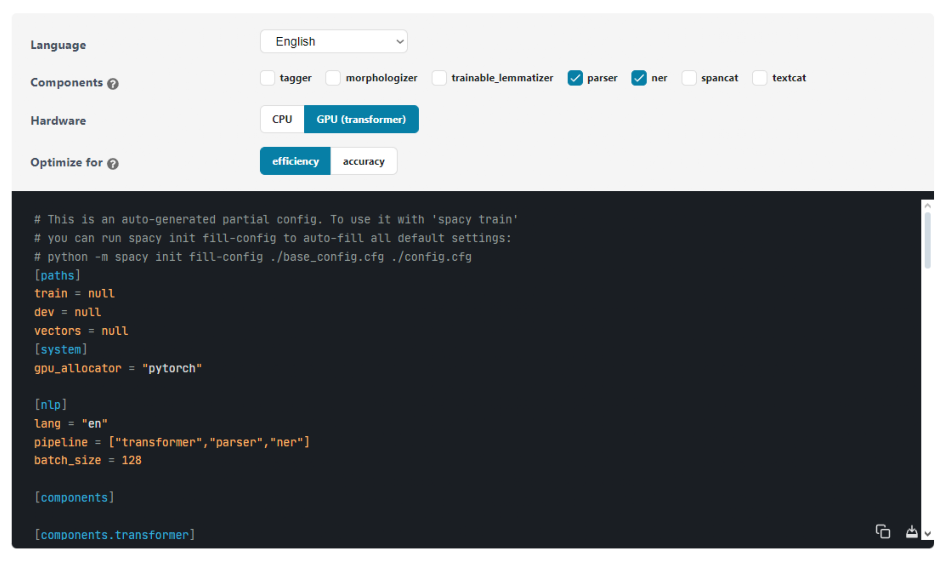

In [89]:
img = mpimg.imread('Screenshot 2024-10-15 131712.png')

plt.figure(figsize=(12, 14))

plt.imshow(img)
plt.axis('off')
plt.show()

In the current task, it is necessary to use the NER parameter, and we can also specify a parser, as mentioned in the beginning. Next, we choose to use transformers, which will allow the model to focus on different parts of the input sequence, thus providing a more efficient understanding of the context and meanings of words in sentences. This requires a lot of computational resources, so it will be trained on the GPU.

The assignment also states, “Select an appropriate model architecture to solve the NER problem” and “Check BERT-based pre-trained models for NER problem”. There are many architectures to choose from in the spaCy library, but the base model has the following parameters:

```[components.transformer.model]
@architectures = "spacy-transformers.TransformerModel.v3"
name = "roberta-base"
tokenizer_config = {"use_fast": true}
```

From the information I found, the current library model is based on just the roberta-base architecture, but slightly improved by the library developers. Therefore, the current parameters can be left and the model can be started

## Config model

In [42]:
!python -m spacy init fill-config base_config.cfg config.cfg

[+] Auto-filled config with all values
[+] Saved config
config.cfg
You can now add your data and train your pipeline:
python -m spacy train config.cfg --paths.train ./train.spacy --paths.dev ./dev.spacy


D:\Programming\Python\DataSpell_Projects\Default Environment 311\Lib\site-packages\transformers\utils\generic.py:441: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(
D:\Programming\Python\DataSpell_Projects\Default Environment 311\Lib\site-packages\transformers\utils\generic.py:309: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(


## Train

In [43]:
!python -m spacy train config.cfg --output ./ --paths.train ./training_data.spacy --paths.dev ./training_data.spacy --gpu-id 0

[i] Saving to output directory: .

D:\Programming\Python\DataSpell_Projects\Default Environment 311\Lib\site-packages\transformers\utils\generic.py:441: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(
D:\Programming\Python\DataSpell_Projects\Default Environment 311\Lib\site-packages\transformers\utils\generic.py:309: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(
D:\Programming\Python\DataSpell_Projects\Default Environment 311\Lib\site-packages\huggingface_hub\file_download.py:1142: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
D:\Programming\Python\DataSpell_Projects\Default Environment 311\Lib\site-packages\tr


[i] Using GPU: 0

=========================== Initializing pipeline ===========================
[+] Initialized pipeline

============================= Training pipeline =============================
[i] Pipeline: ['transformer', 'ner', 'parser']
[i] Initial learn rate: 0.0
E    #       LOSS TRANS...  LOSS NER  LOSS PARSER  ENTS_F  ENTS_P  ENTS_R  DEP_UAS  DEP_LAS  SENTS_F  SCORE 
---  ------  -------------  --------  -----------  ------  ------  ------  -------  -------  -------  ------
  0       0        2347.67    340.47         0.00    0.00    0.00    0.00     0.00     0.00     0.00    0.00
100     200      432235.88  129261.11         0.00   18.24   12.29   35.40     0.00     0.00     0.00    0.09
200     400       70628.79  76141.04         0.00    0.00    0.00    0.00     0.00     0.00     0.00    0.00
300     600       50761.94  20791.63         0.00   69.75   90.78   56.64     0.00     0.00     0.00    0.35
400     800       54726.28  10070.48         0.00   84.21   87.20   8

## Best model and tests

Load the best model and test on randomly generated ChatGPT text.

In [44]:
nlp_ner = spacy.load("model-best")

D:\Programming\Python\DataSpell_Projects\Default Environment 311\Lib\site-packages\transformers\utils\generic.py:309: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(
D:\Programming\Python\DataSpell_Projects\Default Environment 311\Lib\site-packages\spacy_transformers\layers\hf_shim.py:124: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they

In [90]:
doc = nlp_ner("The hikers planned an adventurous journey through the Alps, scaling Mont Blanc, passing by the Matterhorn, and ending their trek at the summit of the Dolomites")

colors = {"MOUNTAIN_NAME": "#668eab"}
options = {"colors": colors}

spacy.displacy.render(doc, options= options, style="ent", jupyter=True)

Obtained a result that successfully extracts the names of mountains from the text.

Let's try an example with a large number of names:

In [97]:
doc = nlp_ner("Mount Everest, known as the tallest mountain in the world, and K2, the second highest peak, are both part of the majestic Himalayas. The Rocky Mountains in North America are home to stunning peaks like Mount Elbert and Mount Rainier, attracting hikers and adventurers alike. In the Andes mountain range, Ojos del Salado, the highest active volcano in the world, stands proudly alongside the picturesque Fitz Roy. Meanwhile, Mont Blanc, the highest mountain in the Alps, and Matterhorn, with its iconic pyramid shape, draw countless climbers each year to experience their beauty. Finally, the Atlas Mountains in Morocco feature Toubkal, the highest peak in North Africa, surrounded by breathtaking landscapes and rich cultural heritage.")

colors = {"MOUNTAIN_NAME": "#668eab"}
options = {"colors": colors}

spacy.displacy.render(doc, options= options, style="ent", jupyter=True)

Here, most of the names were found correctly, but there are also incorrect highlighting, such as "Ojos del Salado" and something that was not highlighted at all - Toubkal. This indicates that the dataset for training did not have enough data.

# Potential improvements

Although the model works well, you can always find a way to improve the model. I suppose that the following can be done to improve it:
- increase the amount of information for training. For ML models, in most cases, increasing the amount of data, including in a "complex form" (in a specific example, this could be several names of mountains that are duplicated or intersected) increases the subsequent accuracy of predicting results.
- check other types of NER model architecture
- experiment with different training parameters (number of training epochs, batch_size, max_batch_items, max_steps, eval_frequency, etc).

In [91]:
!pip freeze > requirements.txt